In [17]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import os

In [ ]:
# --- Setup ---
current_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
input_path = os.path.join(current_dir, 'data', 'processed', 'hotelrec_2013_2017_cleaned_encoded.csv.gz')

In [6]:
# --- Load data ---
hotel_data = pd.read_csv(input_path, usecols=[
    'hotel_name_id', 'sentiment_score', 'sleep quality', 'value', 'rooms', 'service', 'cleanliness', 'location'
])

In [7]:
# --- Group by hotel ---
hotel_grouped = hotel_data.groupby('hotel_name_id').mean().reset_index()

print(f"Grouped hotel dataset shape: {hotel_grouped.shape}")

Grouped hotel dataset shape: (308905, 8)


In [8]:
# --- Fill missing values (if any) ---
structured_features = ['sentiment_score', 'sleep quality', 'value', 'rooms', 'service', 'cleanliness', 'location']
hotel_grouped[structured_features] = hotel_grouped[structured_features].fillna(hotel_grouped[structured_features].mean())

In [9]:
# --- Normalize features ---
scaler = StandardScaler()
hotel_features_scaled = scaler.fit_transform(hotel_grouped[structured_features])

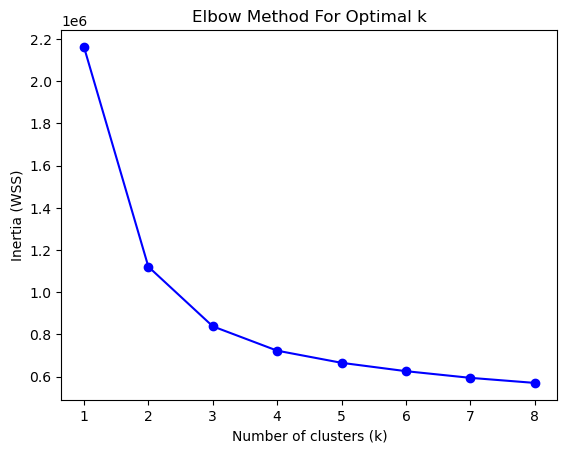

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume X_scaled is your normalized feature matrix

inertias = []
K = range(1, 9)  # Test from 1 to 9 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(hotel_features_scaled)
    inertias.append(kmeans.inertia_)
    
# Plot Inertia (Elbow method)
plt.figure()
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method For Optimal k')
plt.show()




In [10]:
# --- Apply KMeans clustering ---
n_clusters = 5  # or you can try 3, 7, 10 — tune this later
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hotel_grouped['hotel_cluster'] = kmeans.fit_predict(hotel_features_scaled)

/home/ant/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
# --- Save clustered hotel data ---
hotel_grouped.to_csv(os.path.join(current_dir, 'data', 'processed', 'hotel_clusters.csv'), index=False)

print("\nSuccessfully assigned hotel clusters and saved to hotel_clusters.csv")


Successfully assigned hotel clusters and saved to hotel_clusters.csv


In [12]:
hotel_grouped.shape

(308905, 9)

In [13]:
hotel_grouped.head()

,hotel_name_id,sentiment_score,sleep quality,value,rooms,service,cleanliness,location,hotel_cluster
0,0,0.431348,4.857143,4.793103,4.769231,4.850000,4.961538,4.758621,1
1,1,0.147716,3.166667,3.916667,2.769231,3.333333,3.100000,2.933333,4
2,2,0.224727,3.666667,3.900000,3.272727,3.750000,3.947368,3.666667,0
3,3,0.390456,5.000000,4.666667,5.000000,4.833333,4.666667,4.500000,1
4,4,0.416152,5.000000,5.000000,5.000000,4.937500,4.750000,4.600000,1


In [ ]:
# --- Helper function to get predictions ---
def get_predictions(model, X):
    """
    Predict using a trained model.
    
    Args:
        model: Trained model (SVD, LightGBM, etc.)
        X: Input features (for LightGBM) or user-item pairs (for SVD)

    Returns:
        numpy array of predictions
    """
    return model.predict(X)

# --- Helper function to evaluate ---
def evaluate_predictions(y_true, y_pred):
    """
    Evaluate RMSE and MAE.
    
    Args:
        y_true: True ratings
        y_pred: Predicted ratings
        
    Returns:
        rmse, mae
    """
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2